In [55]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [56]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

# Data Exploration

In [57]:
df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20
0,16.0,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316.0,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,5,5,5,5,5,5,5,5,5,5
2,580.0,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,2,2,2,2,2,2,2,2,2,2
3,630.0,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,63,64,63,69,77,83,84,84,86,86
4,850.0,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,3,3,3,3,3,3,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,84070017.0,US,USA,840,NaN,Southeast Utah,Utah,US,38.996171,-110.701396,...,0,0,0,0,0,0,0,0,0,0
3258,84070018.0,US,USA,840,NaN,Southwest Utah,Utah,US,37.854472,-111.441876,...,1,1,1,1,1,2,2,2,2,2
3259,84070019.0,US,USA,840,NaN,TriCounty,Utah,US,40.124915,-109.517442,...,0,0,0,0,0,0,0,0,0,0
3260,84070020.0,US,USA,840,NaN,Weber-Morgan,Utah,US,41.271160,-111.914512,...,1,2,2,2,2,2,2,2,2,2


### we wont be needing the first 12 columns as we are focusing on the reported cases

In [58]:
df = df.iloc[:, 12:-1]

In [59]:
df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
2,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
3,0,0,0,0,0,0,0,0,0,0,...,62,63,64,63,69,77,83,84,84,86
4,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3258,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,2,2,2,2
3259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3260,0,0,0,0,0,0,0,0,0,0,...,1,1,2,2,2,2,2,2,2,2


In [60]:
df.isnull().sum().sum()


0

# getting the cumulative daily cases:

In [61]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases

2020-01-22        0
2020-01-23        0
2020-01-24        0
2020-01-25        0
2020-01-26        0
              ...  
2020-04-24    51493
2020-04-25    53755
2020-04-26    54881
2020-04-27    56259
2020-04-28    58355
Length: 98, dtype: int64

(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text xticklabel objects>)

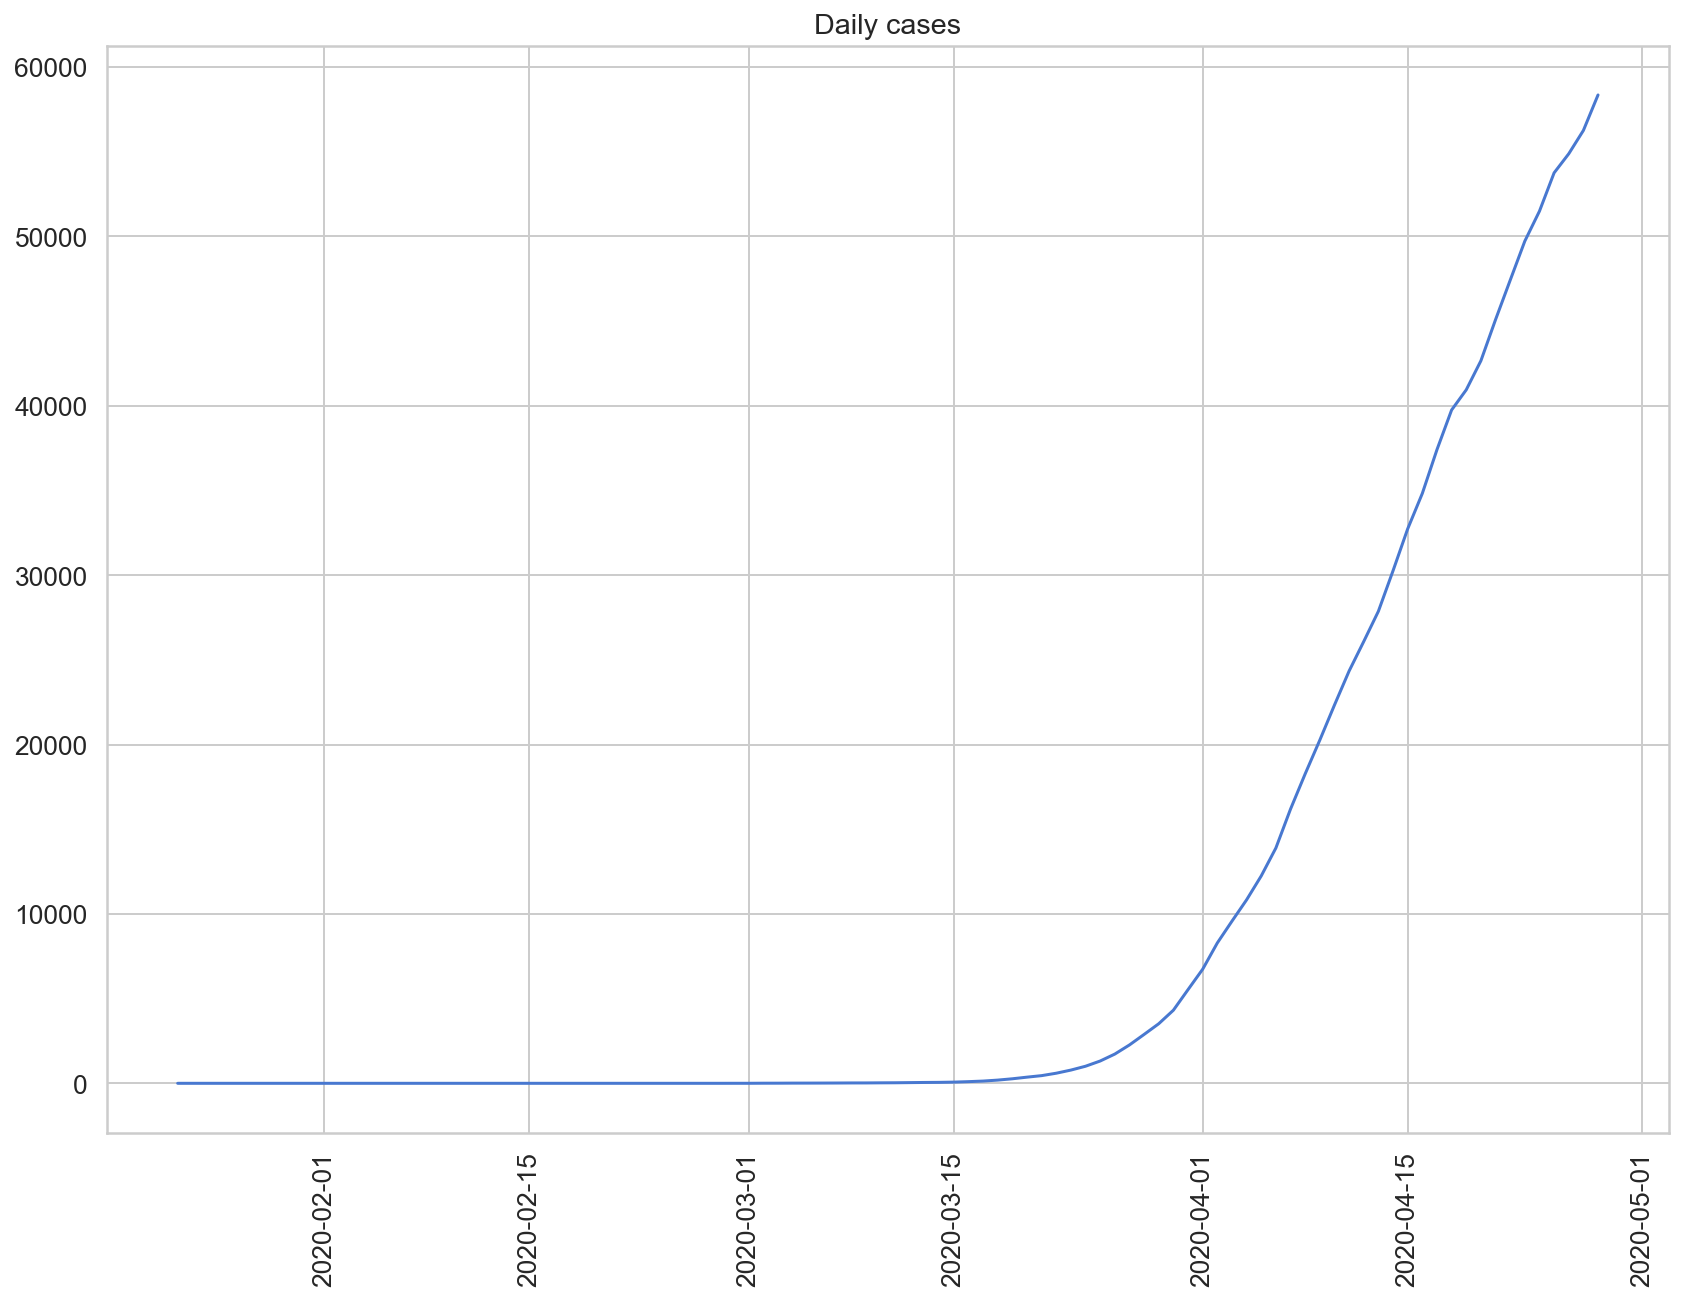

In [62]:
plt.plot(daily_cases)
plt.title("Daily cases");
plt.xticks(rotation=90)

In [63]:
daily_cases.shape

(98,)

# Splitting test data and training data

In [64]:
test_data_size = 30

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(68,)

## We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. 

In [65]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [66]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [67]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [68]:
X_train.shape

torch.Size([62, 5, 1])

In [69]:
X_train[:2]

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [70]:
y_train.shape

torch.Size([62, 1])

In [71]:
train_data[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

# Building a model

### constructor - initialize all helper data and create the layers
### reset_hidden_state - we’ll use a stateless LSTM, so we need to reset the state after each example
### forward - get the sequences, pass all of them through the LSTM layer

In [72]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [73]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

###  using mean squared error to measure the loss

In [74]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 1.5581905841827393 test loss: 2610.51025390625
Epoch 10 train loss: 1.3918061256408691 test loss: 2147.225830078125
Epoch 20 train loss: 0.8820099830627441 test loss: 1036.615478515625
Epoch 30 train loss: 0.5501772165298462 test loss: 394.6891174316406
Epoch 40 train loss: 0.4449993968009949 test loss: 468.03729248046875
Epoch 50 train loss: 0.4220000207424164 test loss: 493.5838928222656


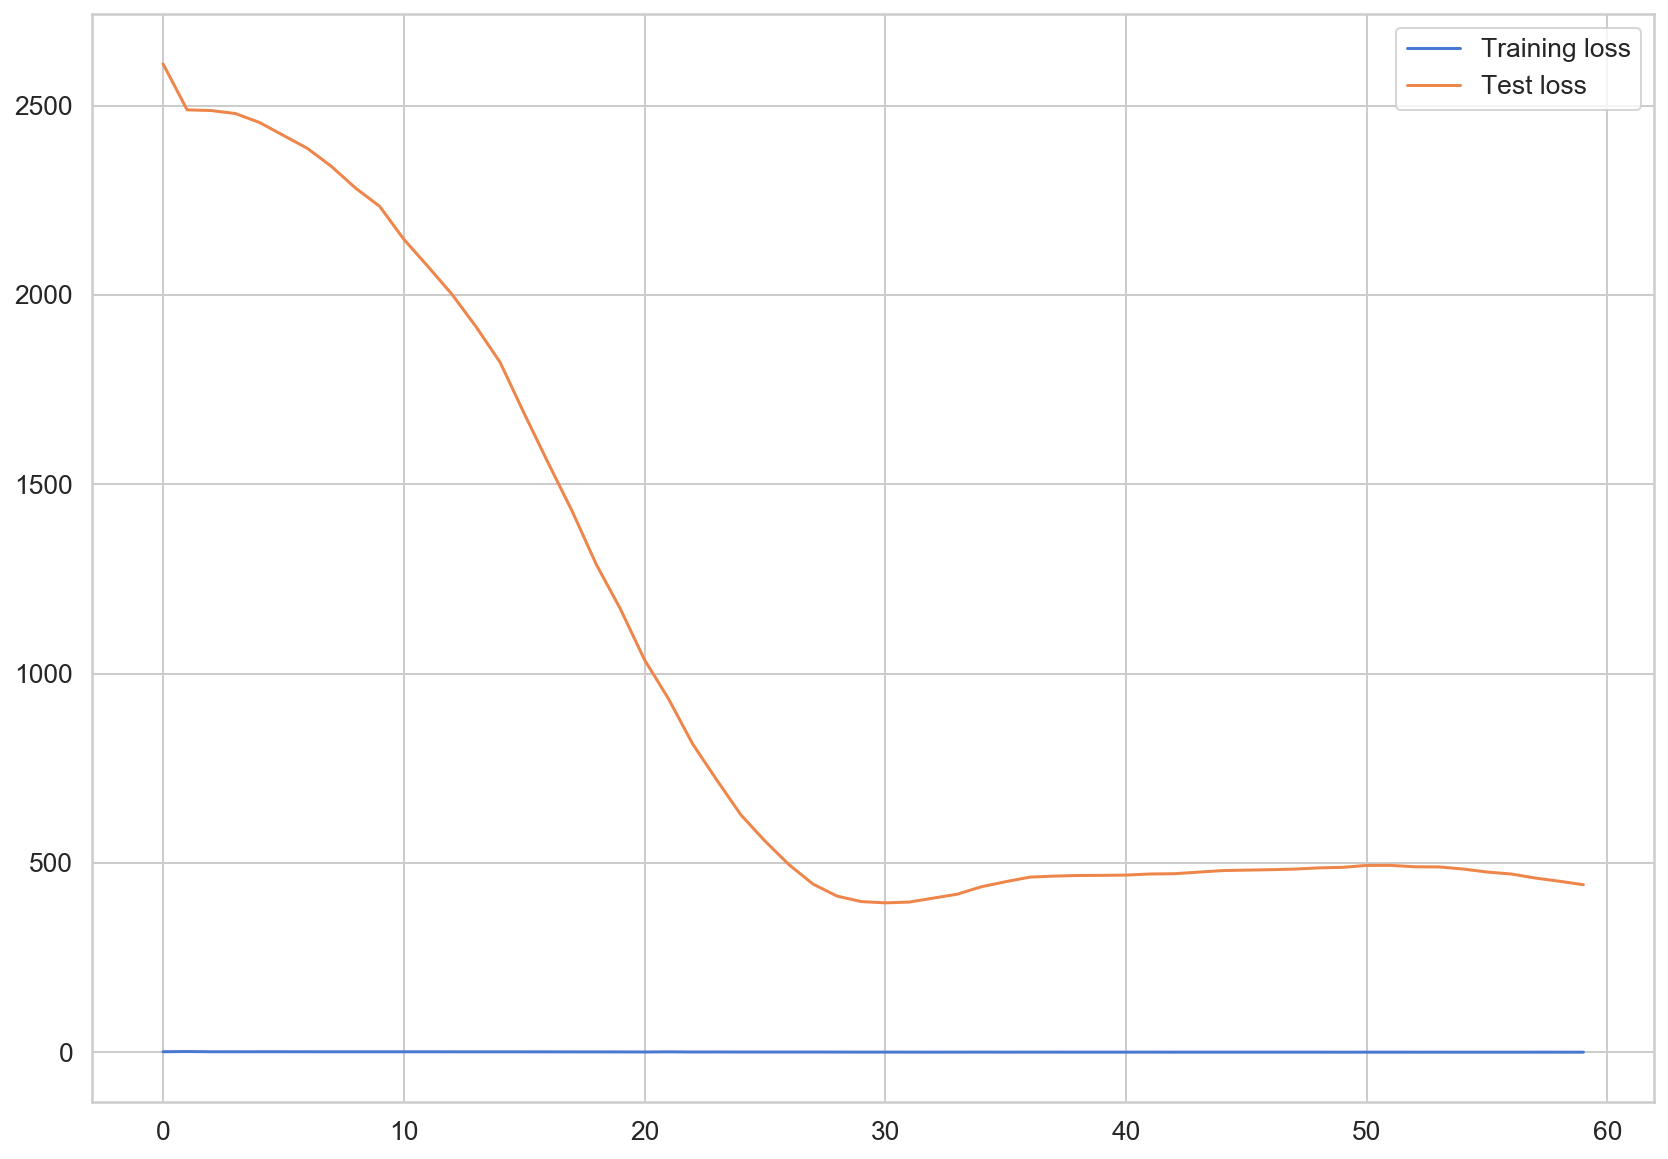

In [75]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

#### Our model can (due to the way we’ve trained it) predict only a single day in the future. We’ll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:

In [76]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [77]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

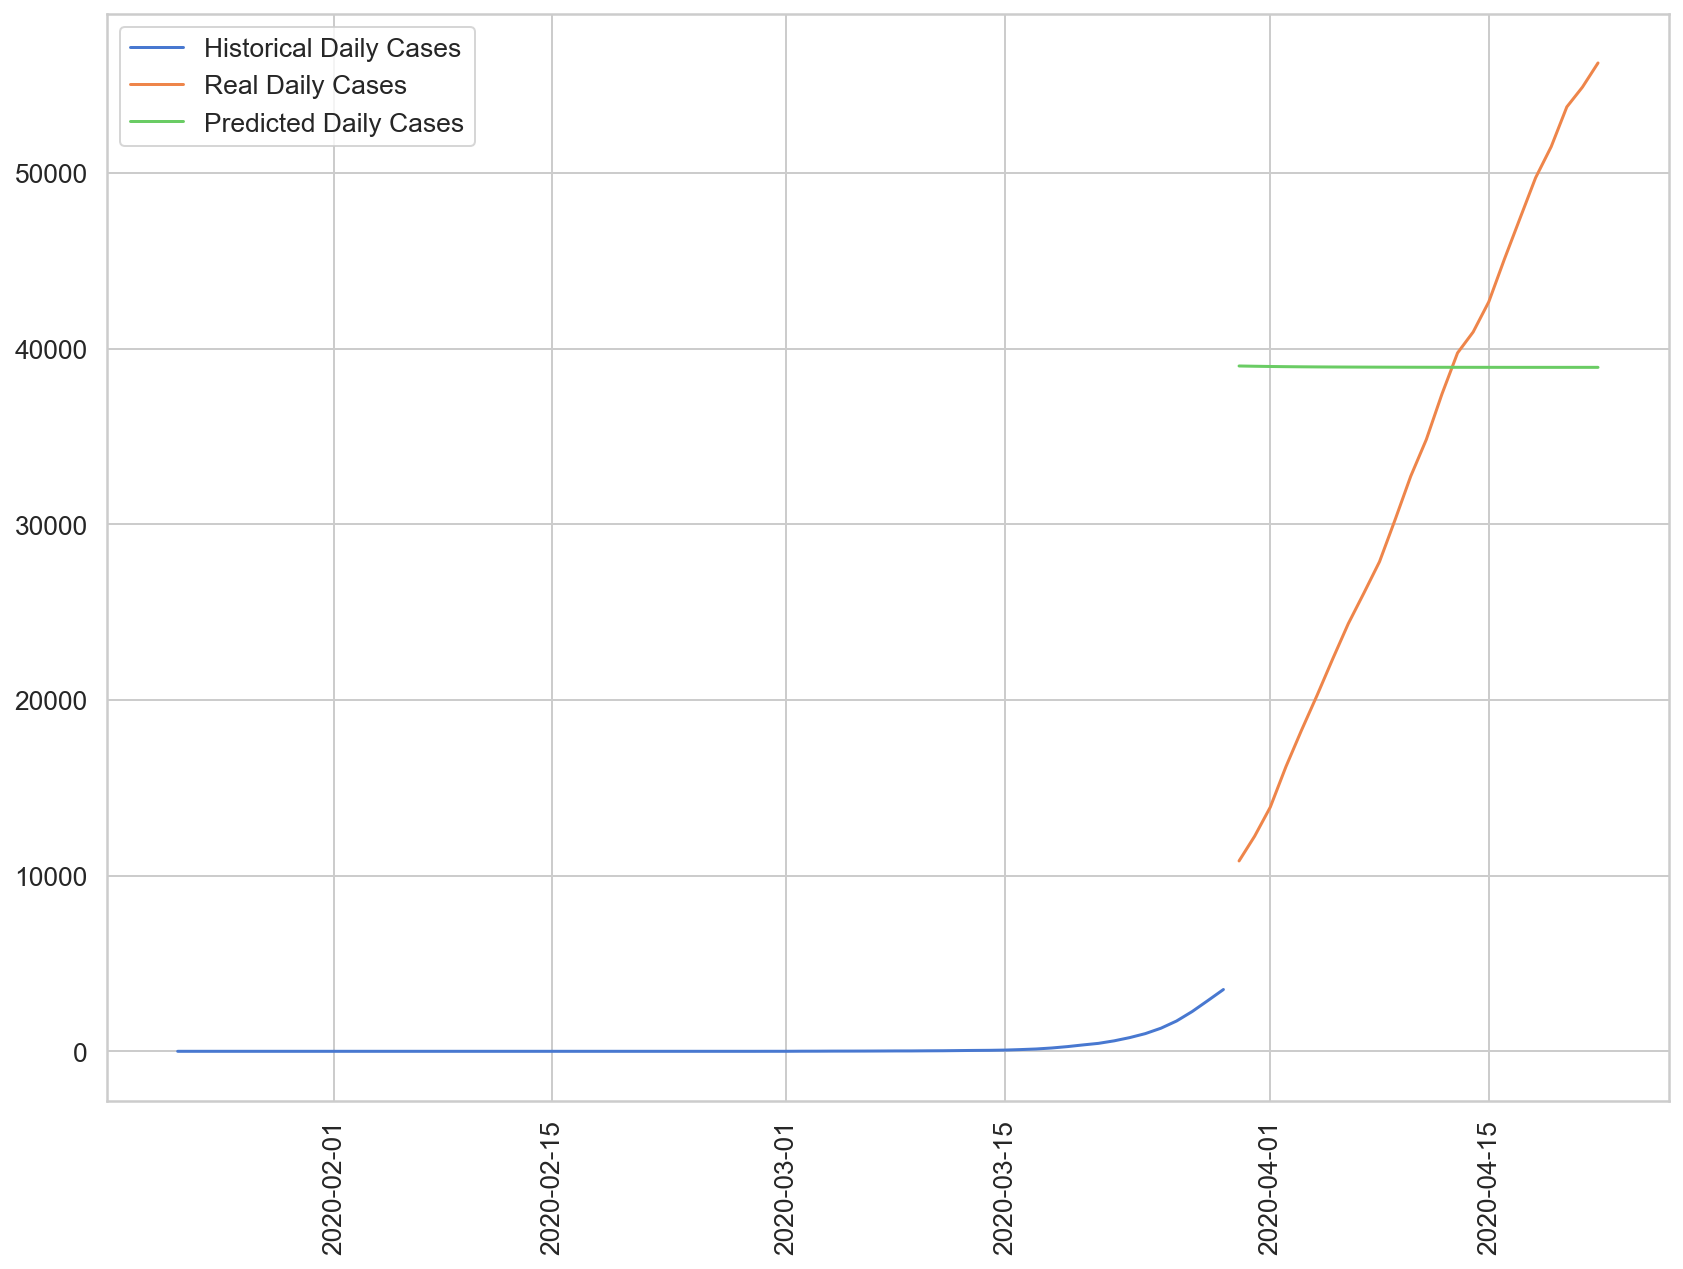

In [78]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.xticks(rotation=90)
plt.legend();

## As the model did not perform well
## Using all data for training

In [79]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(98, 1)

In [80]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.8032020330429077
Epoch 10 train loss: 1.3700706958770752
Epoch 20 train loss: 0.836585283279419
Epoch 30 train loss: 0.7243912220001221
Epoch 40 train loss: 0.4220939576625824
Epoch 50 train loss: 0.3882817029953003


### We’ll use our “fully trained” model to predict the deaths for 12 days into the future:

In [81]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [82]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [83]:
daily_cases.index[-1]

Timestamp('2020-04-28 00:00:00')

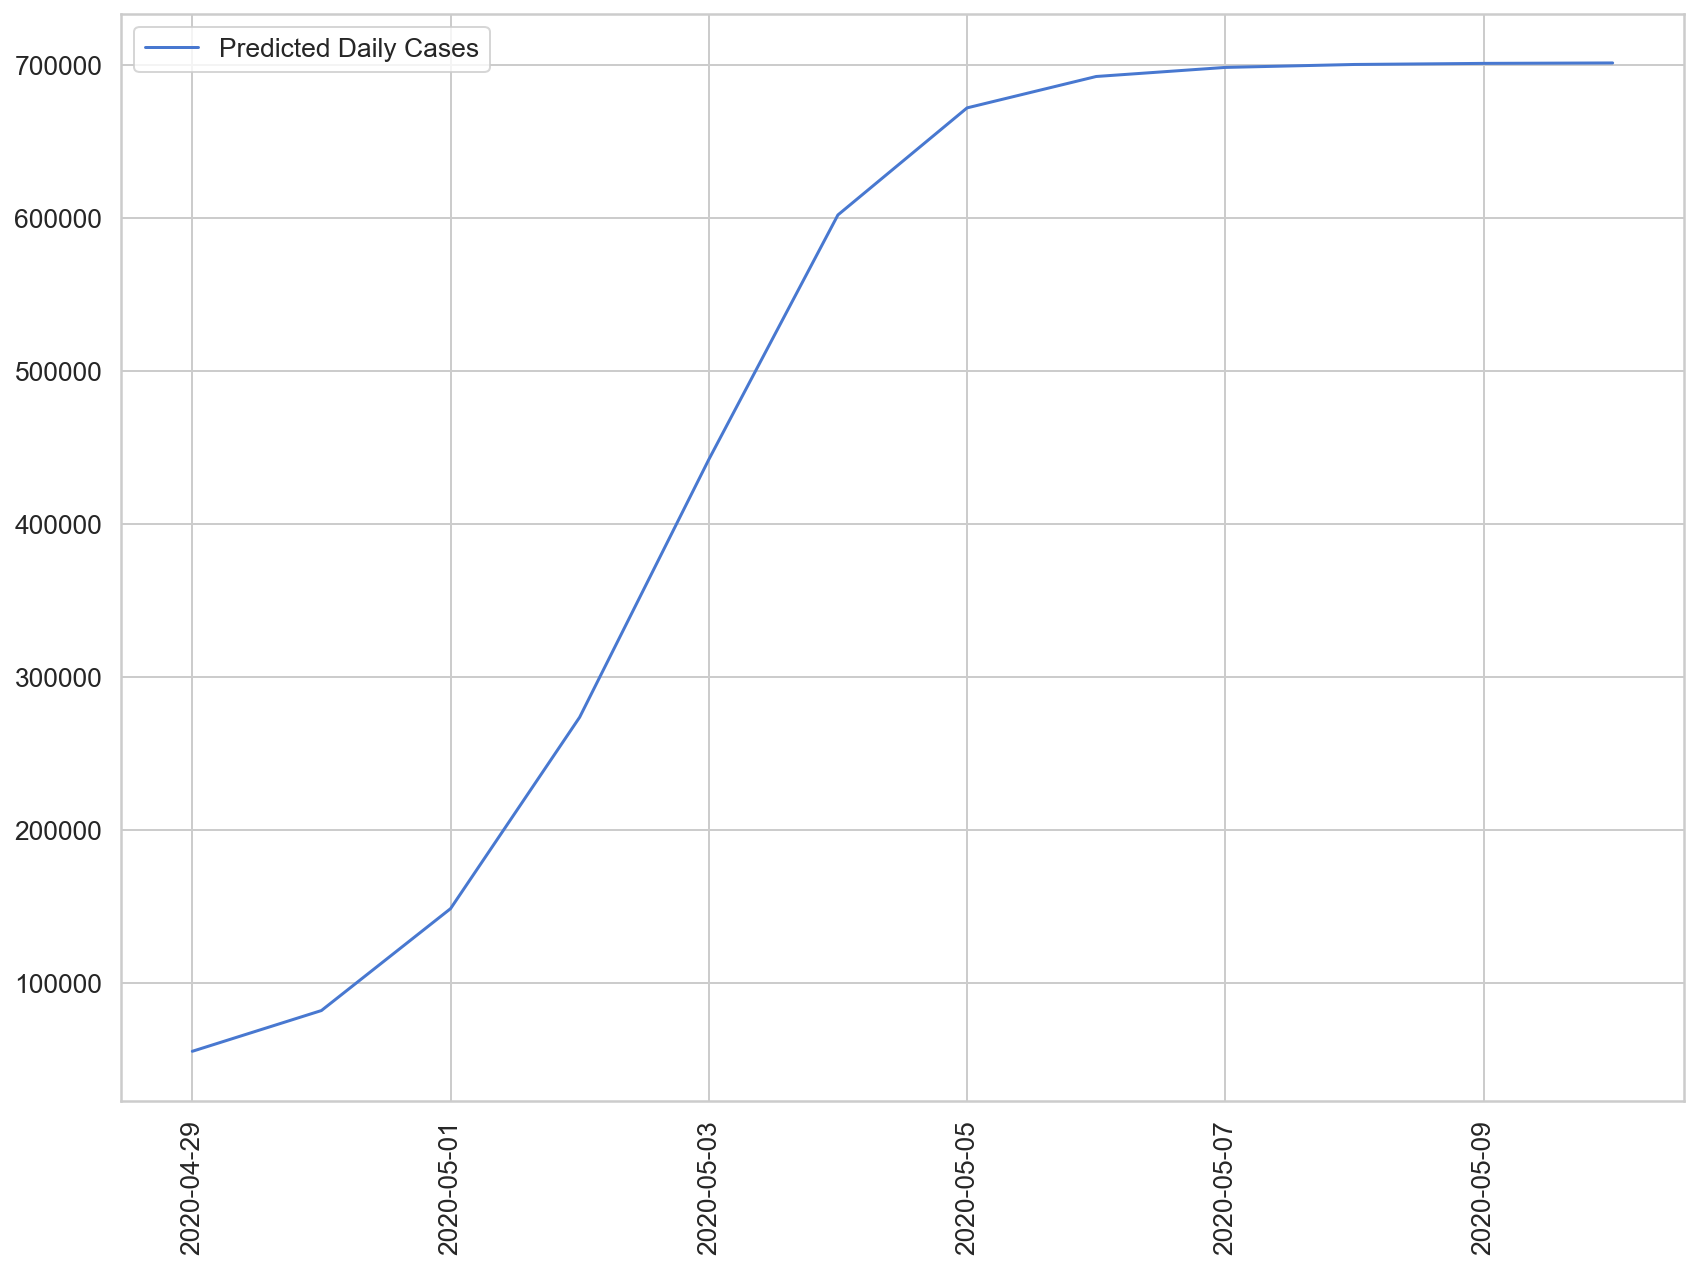

In [84]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.xticks(rotation=90)

plt.legend();

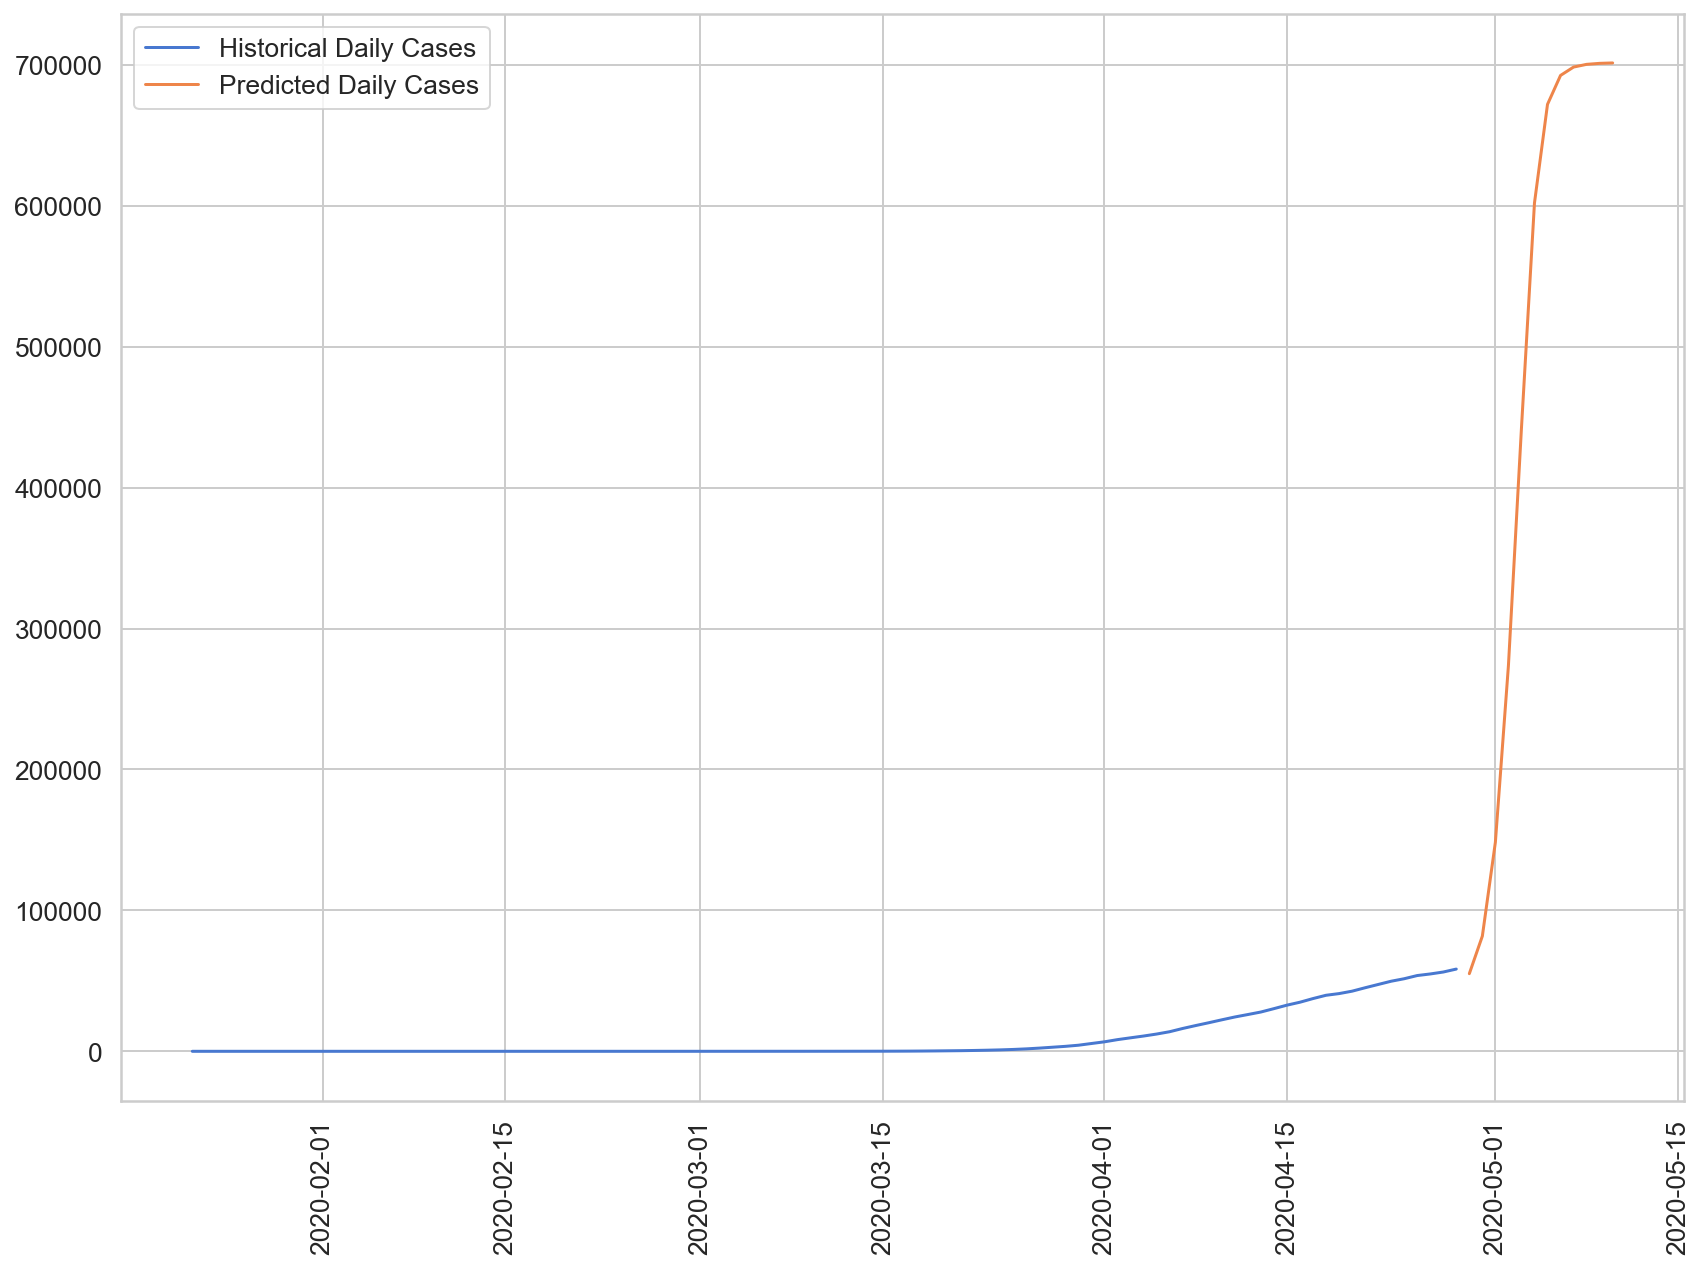

In [85]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.legend();

### Inserting Data to Postgres for displaying on the dashboard

In [86]:
import csv
from urllib.request import urlopen
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT 
import pandas as pd
import io
import requests
from datetime import datetime, timedelta
import time
from datetime import date

In [87]:
## *****NOTE -
## *****This Needs to be Executed only once of the COVID_19, if DB is not present/ postgres is freshly installed.

# Connecting to default "postgres" database and using it we create covid_19 database
db_connection = psycopg2.connect(host='127.0.0.1',dbname="postgres", user="postgres" , password="root")

db_connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT) 

cursor = db_connection.cursor()

# Creating "covid_19" database
#cursor.execute("CREATE DATABASE covid_19;")

#Once the covdid 19 DB is created we connect to "covid_19"

db_connection = psycopg2.connect(host='127.0.0.1',dbname="uml_project", user="postgres" , password="root")

cursor = db_connection.cursor()

db_connection.commit()

In [88]:
db_connection.commit()
cursor.execute("DROP TABLE IF EXISTS health_analytics_covid_us_deaths")

db_connection.commit()

cursor.execute("""CREATE TABLE health_analytics_covid_us_deaths(
                report_date TEXT,
                total INTEGER,
                data_type TEXT,
                category TEXT);""")

db_connection.commit()

In [89]:
db_connection.commit()
for date, value in daily_cases.items():
    query = """INSERT into health_analytics_covid_us_deaths(report_date,total,data_type,category) 
            values('%s',%s,'%s','%s');""" % (str(date), value,'actual', 'death')
    cursor.execute(query)
    
db_connection.commit()

print("Deaths - Actual Data inserted")

for date, value in predicted_cases.items():
    query = """INSERT into health_analytics_covid_us_deaths  
            values('%s',%s,'%s','%s');""" % (date, value,'predicted', 'death')
    cursor.execute(query)
    
db_connection.commit()

print("Deaths - Predicted Data inserted")

Deaths - Actual Data inserted
Deaths - Predicted Data inserted
